# Text Mining and Sentiment Analysis with R

### by [Lorenzo Mario Amorosa](https://github.com/Lostefra)

### Package Installation

*   **tm** for text mining operations like removing numbers, special characters, punctuations and stop words
*   **snowballc** for stemming, which is the process of reducing words to their base or root form
*   **wordcloud** for generating the word cloud plot
*   **RColorBrewer** for color palettes 
*   **syuzhet** for sentiment scores and emotion classification
*   **ggplot2** for plotting graphs
*   **R.utils** for downloading remote file
*   **purrr** for map function
*   **superml** for tf-idf
*   **data.table** for data.table class (input data for ML models)
*   **textreg** for convert.tm.to.character function
*   **rsample** for dataset partitioning
*   **MLmetrics** for validation and test metrics
*   **hash** for dictionary
*   **naivebayes** for Naive Bayes classifier
*   **xgboost** for Gradient Boosting Decision Trees classifier

In [ ]:
# Install
install.packages("tm")  # for text mining
install.packages("SnowballC") # for text stemming
install.packages("wordcloud") # word-cloud generator 
install.packages("RColorBrewer") # color palettes
install.packages("syuzhet") # for sentiment analysis
install.packages("ggplot2") # for plotting graphs
install.packages("R.utils") # for download.file
install.packages("purrr") # for map function
install.packages("superml") # for tf-idf
install.packages("data.table") # for data.table class (input data for ML models)
install.packages("textreg") # for convert.tm.to.character function
install.packages("rsample") # for sampling
install.packages("MLmetrics") # for metrics
install.packages("hash") # for metrics dictionary
install.packages("naivebayes") # for Naive Bayes classifier
install.packages("xgboost") # for Gradient Boosting Decision Trees classifier
# Load
library("tm")
library("SnowballC")
library("wordcloud")
library("RColorBrewer")
library("syuzhet")
library("ggplot2")
library("R.utils")
library("purrr")
library("superml")
library("data.table")
library("textreg")
library("rsample")
library("MLmetrics")
library("hash")
library("naivebayes")
library("xgboost")

In [42]:
# Download the dataset
download.file("https://raw.githubusercontent.com/Lostefra/tweets_sentiment_analysis_R/main/data/Tweets.csv", 
              "tweets.csv.gz")
gunzip('tweets.csv.gz')

### Input read

The Twitter Airline Sentiment dataset consists of the reviews submitted by the individuals who traveled through various Airlines in United States in 2015. The reviews are categorized into 3 categories: positive, negative, neutral.

The dataset can be found here: https://www.kaggle.com/crowdflower/twitter-airline-sentiment

The input csv file contains 30 fiels, but among them only two are relevant for the purposes of this analysis: "text", a string representing the content of the tweet, and "airline_sentiment", which is the tweet label.

The first step is to extract the tweet texts as a vector from a dataframe, and then to load that Vector as a Corpus. In R, a Corpus is a collection of text document(s) to apply text mining or NLP routines on.

In [43]:
# Load the dataframe
df <- data.frame(read.csv("tweets.csv", header = TRUE))[c("text", "airline_sentiment")]
head(df, 10)

,text,airline_sentiment
,<chr>,<chr>
1,@VirginAmerica What @dhepburn said.,neutral
2,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
3,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
4,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
5,@VirginAmerica and it's a really big bad thing about it,negative
6,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing. it's really the only bad thing about flying VA,negative
7,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",positive
8,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",neutral
9,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive


In [44]:
# Extract the tweet texts as vector
text <- df[["text"]]

# Load the data as a corpus
textDoc <- VCorpus(VectorSource(text))

### Cleaning up Text Data

Cleaning the text data starts with making transformations like removing special characters from the text. This is done using the `tm_map()` function to remove special characters such as html tokens `&amp;`, `&lt;` and `&gt;`. URLs which often represent embedded images in tweets are removed as well. 

The next step is to remove the unnecessary whitespace, numbers and punctuation and convert the text to lower case.

Then stopwords are removed, which are the most commonly occurring words in a language and have very little value in terms of gaining useful information. 

The tag to airline companies, such as "VirginAmerica", "united", "SouthwestAir", "JetBlue", "USAirways", "AmericanAir", which occur in each tweets, are removed since they not bring useful information. The same for the word "flight", which is very frequent.

The last step is text stemming, which is the process of reducing the word to its root form.

In [45]:
remove <- content_transformer(function (source_text, pattern) gsub(pattern, "", source_text))
# Replace html tokens (pattern) with empty string in source text
textDoc <- tm_map(textDoc, remove, "&amp;|&lt;|&gt;")
# Remove images URLs
textDoc <- tm_map(textDoc, remove, "https?://t.co/[a-zA-Z0-9]{10}")
# Convert the text to lower case
textDoc <- tm_map(textDoc, content_transformer(tolower))
# Remove numbers
textDoc <- tm_map(textDoc, removeNumbers)
# Remove english common stopwords
textDoc <- tm_map(textDoc, removeWords, stopwords("english"))
# Remove stopwords related to the scenario, specifying them as a character vector
textDoc <- tm_map(textDoc, removeWords, c("virginamerica", "united", "southwestair", 
                                          "jetblue", "usairways", "americanair",
                                          "flight"))
# Remove punctuations
textDoc <- tm_map(textDoc, removePunctuation)
# Eliminate extra white spaces
textDoc <- tm_map(textDoc, stripWhitespace)
# Text stemming using Porter's stemming algorithm - which reduces words to their root form
textDoc <- tm_map(textDoc, stemDocument)

Inspect content differences after clean up:

In [46]:
index <- 8
text[index]
strwrap(textDoc[[index]])

[1] "@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"

[1] "realli miss prime opportun men without hat parodi"

### Building the Term Document Matrix

After cleaning the text data, the next step is to count the occurrence of each word, to identify popular or trending topics. Using the function `TermDocumentMatrix()` from the text mining package, it can be build a Document Matrix – a table containing the frequency of words.

In [47]:
# Build a term-document matrix
textDoc_tdm <- TermDocumentMatrix(textDoc)
tdm_m <- as.matrix(textDoc_tdm)
# Sort by decreasing value of frequency
tdm_v <- sort(rowSums(tdm_m),decreasing=TRUE)
tdm_d <- data.frame(word = names(tdm_v),freq=tdm_v)
# Display the top 10 most frequent words
head(tdm_d, 10)

,word,freq
,<chr>,<dbl>
thank,thank,1689
get,get,1619
hour,hour,1158
can,can,1118
cancel,cancel,1056
help,help,1042
now,now,1024
servic,servic,991
delay,delay,983


Plotting of the top 10 most frequent words using a bar chart.

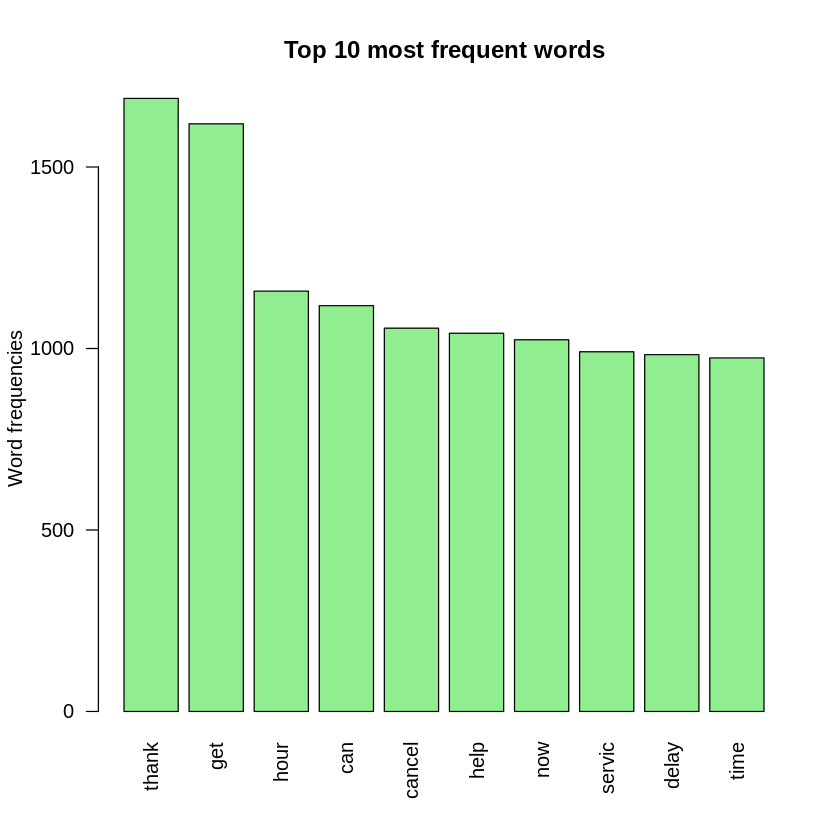

In [48]:
# Plot the most frequent words
barplot(tdm_d[1:10,]$freq, las = 2, names.arg = tdm_d[1:10,]$word,
        col ="lightgreen", main ="Top 10 most frequent words",
        ylab = "Word frequencies")

A word cloud is one of the most popular ways to visualize and analyze qualitative data. It’s an image composed of keywords found within a body of text, where the size of each word indicates its frequency in that body of text. It is useful because it shows additional words that occur frequently and could be of interest for further analysis. 

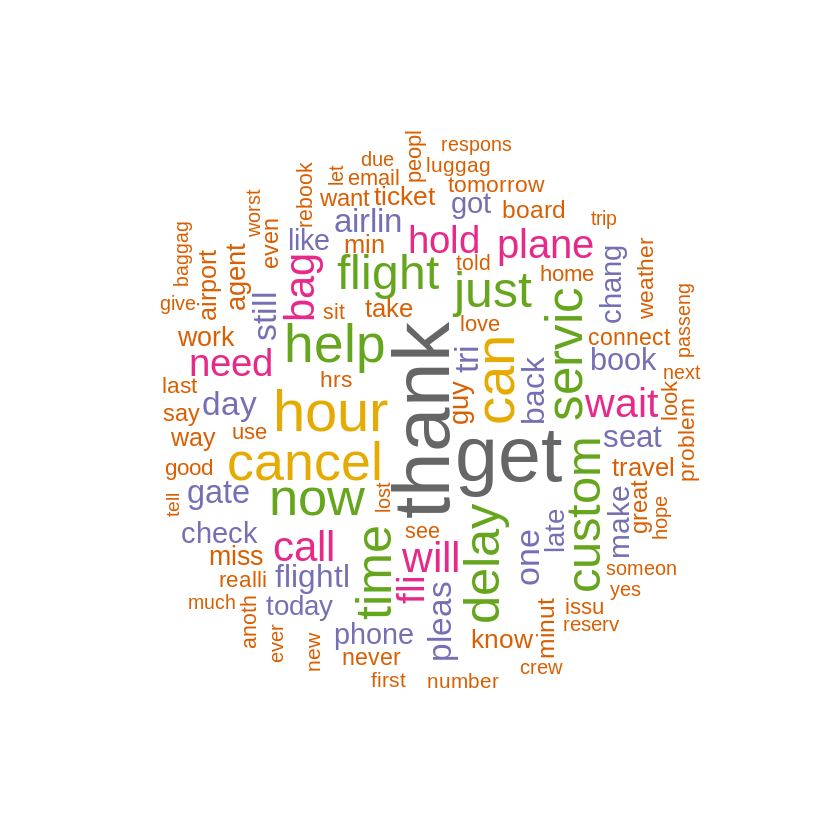

In [49]:
# Generate word cloud
set.seed(1234)
wordcloud(words = tdm_d$word, freq = tdm_d$freq, min.freq = 5,
          max.words=100, random.order=FALSE, rot.per=0.40, 
          colors=brewer.pal(8, "Dark2"))

### Word Association

Correlation is a statistical technique that can demonstrate whether, and how strongly, pairs of variables are related. This technique can be used effectively to analyze which words occur most often in association with the most frequently occurring words in the survey responses, which helps to see the context around these words. 

`findAssocs` function shows which are the most correlated words to a given term (according to a correlation threshold).

In [50]:
# Find associations 
findAssocs(textDoc_tdm, terms = c("hour","cancel","servic"), corlimit = 0.15)

$hour
hold wait 
0.26 0.16 

$cancel
  flightl    flight flightlat  flightat 
     0.68      0.41      0.26      0.16 

$servic
 custom terribl 
   0.58    0.16

In [51]:
# Find associations for words that occur at least 900 times
findAssocs(textDoc_tdm, terms = findFreqTerms(textDoc_tdm, lowfreq = 900), corlimit = 0.15)

$can
numeric(0)

$cancel
  flightl flightlat  flightat 
     0.68      0.26      0.16 

$custom
numeric(0)

$delay
numeric(0)

$flight
numeric(0)

$get
home 
0.16 

$help
numeric(0)

$hour
hold wait 
0.26 0.16 

$just
numeric(0)

$now
right 
 0.16 

$servic
terribl 
   0.16 

$thank
numeric(0)

$time
numeric(0)

### Sentiment Scores

Sentiments can be classified as positive, neutral or negative. They can also be represented on a numeric scale, to better express the degree of positive or negative strength of the sentiment contained in a body of text.

The Syuzhet package is used for generating sentiment scores, which has four sentiment dictionaries.

The `get_sentiment` function accepts two arguments: a character vector (of sentences or words) and a method. The selected method determines which of the four available sentiment extraction methods will be used. The four methods are `syuzhet` (this is the default), `bing`, `afinn` and `nrc`. Each method uses a different scale and hence returns slightly different results.

To each document is assigned as sentiment score the sum of the sentiments of all its terms. The scales for sentiment scores for each method are the following:
* `syuzhet`: it is decimal and ranges from -1(indicating most negative) to +1(indicating most positive) for each word.
* `bing`: binary scale with -1 indicating negative and +1 indicating positive sentiment.
* `afinn`: integer scale ranging from -5 to +5.
* `nrc`: binary scale (-1, 1).

Note that a positive `mean`/`median` value of these methods implies that the overall sentiment of the documents is positive. 

Regarding the lexicons, there are numerous words that have neutral sentiment, so we won't find them. What's worth mentioning is the fact that thes methods work on unigrams, and therefore it won't take into account sarcasm or negated text.

In [52]:
# Inspection of a dictionary
head(get_sentiment_dictionary('syuzhet'))

,word,value
,<chr>,<dbl>
1,abandon,-0.75
2,abandoned,-0.50
3,abandoner,-0.25
4,abandonment,-0.25
5,abandons,-1.00
6,abducted,-1.00


In [53]:
text_split <- strsplit(text, "\n")

In [54]:
# syuzhet: [-1, 1] decimal
syuzhet_vector <- get_sentiment(text, method="syuzhet")
# see the first 10 elements of the syuzhet_vector, which are the sentiments of the first 10 documents
for (i in 1:10){
  cat(paste(syuzhet_vector[i], text_split[i], "\n", sep="\t"))
}
cat("\nSummary\n")
summary(syuzhet_vector)

0	@VirginAmerica What @dhepburn said.	
-0.25	@VirginAmerica plus you've added commercials to the experience... tacky.	
0	@VirginAmerica I didn't today... Must mean I need to take another trip!	
-1.35	@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse	
-0.5	@VirginAmerica and it's a really big bad thing about it	
-0.75	c("@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.", "it's really the only bad thing about flying VA")	
1.05	@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)	
-0.15	@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP	
0.8	@virginamerica Well, I didn't…but NOW I DO! :-D	
1.25	@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.	

Summary


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-4.3500 -0.2500  0.2500  0.2494  0.8000  5.0500 

In [55]:
# bing: (-1, 1) binary
bing_vector <- get_sentiment(text, method="bing")
# see the first 10 elements of the bing_vector, which are the sentiments of the first 10 documents
for (i in 1:10){
  cat(paste(bing_vector[i], text_split[i], "\n", sep="\t"))
}
cat("\nSummary\n")
summary(bing_vector)

0	@VirginAmerica What @dhepburn said.	
-1	@VirginAmerica plus you've added commercials to the experience... tacky.	
0	@VirginAmerica I didn't today... Must mean I need to take another trip!	
-2	@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse	
-1	@VirginAmerica and it's a really big bad thing about it	
-1	c("@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.", "it's really the only bad thing about flying VA")	
1	@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)	
-2	@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP	
1	@virginamerica Well, I didn't…but NOW I DO! :-D	
2	@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.	

Summary


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-6.00000 -1.00000  0.00000 -0.07876  1.00000  6.00000 

In [56]:
# afinn: [-5, 5] integer
afinn_vector <- get_sentiment(text, method="afinn")
# see the first 10 elements of the afinn_vector, which are the sentiments of the first 10 documents
for (i in 1:10){
  cat(paste(afinn_vector[i], text_split[i], "\n", sep="\t"))
}
cat("\nSummary\n")
summary(afinn_vector)

0	@VirginAmerica What @dhepburn said.	
0	@VirginAmerica plus you've added commercials to the experience... tacky.	
0	@VirginAmerica I didn't today... Must mean I need to take another trip!	
-5	@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse	
-2	@VirginAmerica and it's a really big bad thing about it	
-4	c("@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.", "it's really the only bad thing about flying VA")	
4	@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)	
0	@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP	
0	@virginamerica Well, I didn't…but NOW I DO! :-D	
7	@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.	

Summary


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-13.0000  -1.0000   0.0000   0.4566   2.0000  17.0000 

In [57]:
# nrc: (-1, 1) binary
nrc_vector <- get_sentiment(text, method="nrc")
# see the first 10 elements of the nrc_vector, which are the sentiments of the first 10 documents
for (i in 1:10){
  cat(paste(nrc_vector[i], text_split[i], "\n", sep="\t"))
}
cat("\nSummary\n")
summary(nrc_vector)

0	@VirginAmerica What @dhepburn said.	
0	@VirginAmerica plus you've added commercials to the experience... tacky.	
0	@VirginAmerica I didn't today... Must mean I need to take another trip!	
-2	@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse	
-1	@VirginAmerica and it's a really big bad thing about it	
1	c("@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.", "it's really the only bad thing about flying VA")	
-1	@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)	
2	@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP	
0	@virginamerica Well, I didn't…but NOW I DO! :-D	
1	@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.	

Summary


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-5.0000  0.0000  0.0000  0.3719  1.0000  6.0000 

Because these different methods use different scales, it’s better to convert their output to a common scale before comparing them. This basic scale conversion can be done easily using R’s built-in `sign` function, which converts all positive number to 1, all negative numbers to -1 and all zeros remain 0. In case all the values in the same column are 1 or -1 then all the methods agree on the sentiment of the related document.

The methods from the syuzhet package are compared with the original labels given in the dataset, after that the need transformation to numeric values of the labels is performed.

In [58]:
get_numeric <- function(x) {
  if (x == "positive") {
    return (1)
  } 
  else if (x == "negative") {
    return (-1)
  }
  else {
    return (0)
  }
}

airline_sentiment_list <- map(df[["airline_sentiment"]], get_numeric)
airline_sentiment <- as.numeric(unlist(airline_sentiment_list))

In [59]:
# compare the first rows of each vector using sign function
rbind(
  sign(head(syuzhet_vector, 10)),
  sign(head(bing_vector, 10)),
  sign(head(afinn_vector, 10)),
  sign(head(nrc_vector, 10)),
  head(airline_sentiment, 10)
)

0,-1,0,-1,-1,-1,1,-1,1,1
0,-1,0,-1,-1,-1,1,-1,1,1
0,0,0,-1,-1,-1,1,0,0,1
0,0,0,-1,-1,1,-1,1,0,1
0,1,0,-1,-1,-1,1,0,1,1


### Emotion Classification

Emotion classification is built on the NRC Word-Emotion Association Lexicon (aka EmoLex), which is a list of English words and their associations with eight basic emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and two sentiments (negative and positive). The annotations were manually done by crowdsourcing.

The function `get_nrc_sentiments` returns a data frame with each row representing a document and ten columns, eight for the emotions and two for positive/negative sentiment valence. The values which appear in these columns are the number of words related to that specific emotion/sentiment for each document.

In [ ]:
emotions_df <- get_nrc_sentiment(text)
head(emotions_df,10)

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,3,1,1,2,1,1,2,1,3,1
5,1,0,1,1,0,1,0,0,1,0
6,1,1,1,2,1,1,0,1,1,2
7,0,2,0,0,0,0,1,0,1,0
8,0,1,0,0,0,0,0,0,0,2
9,0,0,0,0,0,0,0,0,0,0


It is possible to extract from the corpus the documents related to a given emotion:

In [ ]:
indexes <- which(emotions_df$anger > 0)
head(text[indexes], 5)

[1] "@VirginAmerica it's really aggressive to blast obnoxious \"entertainment\" in your guests' faces &amp; they have little recourse"            
[2] "@VirginAmerica and it's a really big bad thing about it"                                                                                     
[3] "@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA"    
[4] "@VirginAmerica did you know that suicide is the second leading cause of death among teens 10-24"                                             
[5] "@VirginAmerica So excited for my first cross country flight LAX to MCO I've heard nothing but great things about Virgin America. #29DaysToGo"

Two plots charts are proposed to help visually analyze the emotions in this text corpus, performing some data transformation and clean-up steps before plotting charts.

The first plot shows the total number of instances of words in the text, associated with each of the eight emotions.

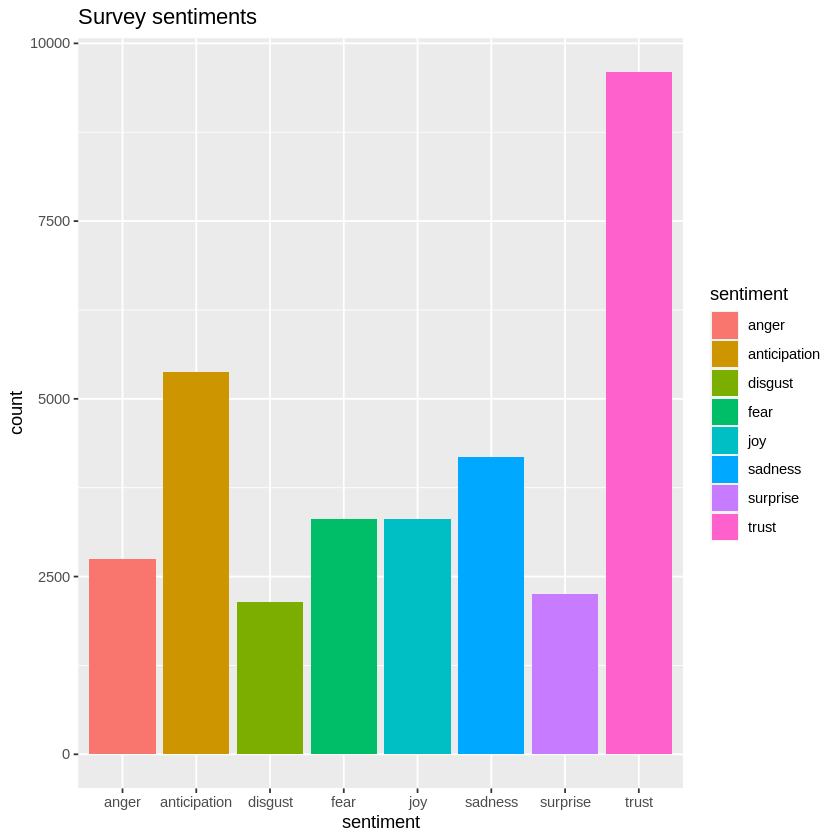

In [ ]:
# Transpose
t_emotions_df <- data.frame(t(emotions_df))
# The function rowSums computes column sums across rows for each level of a grouping variable.
t_emotions_df_sum <- data.frame(rowSums(t_emotions_df))
# Transformation and cleaning
names(t_emotions_df_sum)[1] <- "count"
t_emotions_df_sum <- cbind("sentiment" = rownames(t_emotions_df_sum), t_emotions_df_sum)
rownames(t_emotions_df_sum) <- NULL
t_emotions_df_sum2 <- t_emotions_df_sum[1:8,]
# Plot One - count of words associated with each sentiment
quickplot(
  sentiment, 
  data=t_emotions_df_sum2, 
  weight=count, 
  geom="bar", 
  fill=sentiment, 
  ylab="count")+ggtitle("Survey sentiments")

A deeper understanding of the overall emotions occurring in the survey response can be gained by comparing these number as a percentage of the total number of meaningful words.

This bar plot allows for a quick and easy comparison of the proportion of words associated with each emotion in the text.

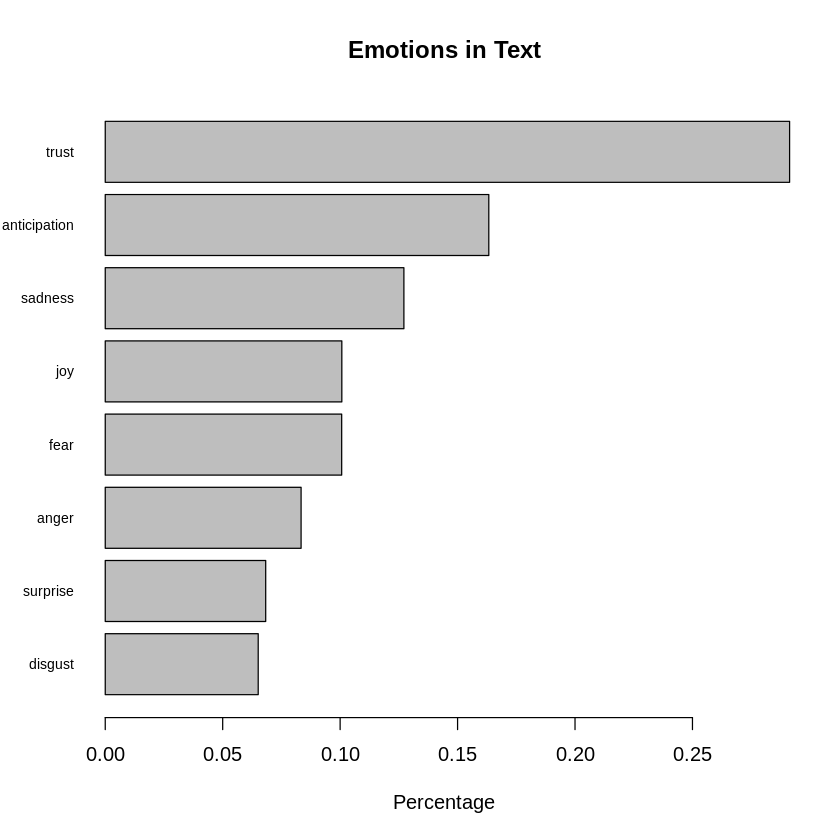

In [ ]:
#Plot two - count of words associated with each sentiment, expressed as a percentage
barplot(
  sort(colSums(prop.table(emotions_df[, 1:8]))), 
  horiz = TRUE, 
  cex.names = 0.7, 
  las = 1, 
  main = "Emotions in Text", xlab="Percentage"
)

It is possible to investigate which are the most ambiguous documents using the function `mixed_messages`, i.e. the documents which contains a large number of both positive and negative words. The emotional entropy ranges from 0 (when no ambiguity is present) to 1 (when the ambiguity is maximum).

In [ ]:
mixed_messages_raw <- lapply(text, mixed_messages)
mixed_messages_matrix <- do.call(rbind, mixed_messages_raw)
mixed_messages_df <- data.frame(mixed_messages_matrix, text, stringsAsFactors = FALSE)[,-2]
head(mixed_messages_df, 10)

,entropy,text
,<dbl>,<chr>
1,0.0000000,@VirginAmerica What @dhepburn said.
2,0.0000000,@VirginAmerica plus you've added commercials to the experience... tacky.
3,0.0000000,@VirginAmerica I didn't today... Must mean I need to take another trip!
4,0.8112781,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
5,1.0000000,@VirginAmerica and it's a really big bad thing about it
6,0.9182958,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing. it's really the only bad thing about flying VA
7,0.9182958,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)"
8,1.0000000,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"
9,0.0000000,"@virginamerica Well, I didn't…but NOW I DO! :-D"


It is possible to see the most emotionally controversial documents by sorting by entropy.

In [ ]:
head(mixed_messages_df[order(mixed_messages_df$entropy, decreasing = TRUE),],10)

,entropy,text
,<dbl>,<chr>
5,1,@VirginAmerica and it's a really big bad thing about it
8,1,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"
25,1,@VirginAmerica you guys messed up my seating.. I reserved seating with my friends and you guys gave my seat away ... 😡 I want free internet
29,1,@VirginAmerica amazing to me that we can't get any cold air from the vents. #VX358 #noair #worstflightever #roasted #SFOtoBOS
70,1,@VirginAmerica everything was fine until you lost my bag
74,1,@VirginAmerica your airline is awesome but your lax loft needs to step up its game. $40 for dirty tables and floors? http://t.co/hy0VrfhjHt
85,1,@VirginAmerica it was a disappointing experience which will be shared with every business traveler I meet. #neverflyvirgin
86,1,@VirginAmerica I’m having trouble adding this flight my wife booked to my Elevate account. Help? http://t.co/pX8hQOKS3R
93,1,@VirginAmerica I like the TV and interesting video . Just disappointed in Cancelled Flightled flight when other flights went out to jfk on Saturday .


# Machine Learning for Multiclass Classification

In this section machine learning models (such as Gradient boosting decision trees, Naive Bayes) are trained to predict the sentiment of the tweets. 

Since some operations may require several minutes, if the flag variable `use_checkpoints` is set to `TRUE` then intermidiate results (such as TF-IDF encoding) are retrieved from [Github](https://github.com/Lostefra/tweets_sentiment_analysis_R).

In [2]:
use_checkpoints <- TRUE

The variable `best_metrics` will store the metrics evaluated on the test set of the best models in order to allow models' comparison.

In [3]:
best_metrics <- hash()

### Data partitioning and TF-IDF

It is firstly defined a function to convert the nominal category of sentiments into a numeric category.

In [ ]:
get_class <- function(x) {
  if (x == "positive") {
    return (2)
  } 
  else if (x == "negative") {
    return (0)
  }
  else {
    return (1)
  }
}

The dataset is partioned into training, validation and test sets, and the TF-IDF features are computed using `superml` package. In the end, we end up with `x_train`, `x_val` and `x_test` datatables which contain for each tweet its TF-IDF representations and its sentiment label.

In [4]:
if(!use_checkpoints){
  # Convert airline_sentiment to numeric values
  airline_sentiment_list <- map(df[["airline_sentiment"]], get_class)
  airline_sentiment <- as.numeric(unlist(airline_sentiment_list))

  # Partion the dataset: 80% training, 10% validation, 10% test
  data <- data.table(text = convert.tm.to.character(textDoc), target = airline_sentiment) # dim(data) = 14640 × 2
  data_split <- initial_split(data, prop = .8)
  train <- training(data_split) # dim(train) = 11713 × 2 
  val_test  <- testing(data_split) # dim(val_test) = 2927 × 2
  test_split <- initial_split(val_test, prop = .5)
  val <- training(test_split) # dim(val) = 1464 × 2
  test  <- testing(test_split) # dim(test) = 1463 × 2

  # Compute TF-IDF features on training data, transform all sets and bind with labels
  tfv <- TfIdfVectorizer$new(remove_stopwords = FALSE, ngram_range = c(1,1))
  tfv$fit(train$text)
  train_tf_features <- tfv$transform(train$text) # dim(train_tf_features) = 11713 × 8865
  val_tf_features <- tfv$transform(val$text) # dim(val_tf_features) = 1464 × 8865
  test_tf_features <- tfv$transform(test$text) # dim(test_tf_features) = 1463 × 8865
  x_train <- data.table(cbind(train_tf_features, target = train$target))
  x_val <- data.table(cbind(val_tf_features, target = val$target))
  x_test <- data.table(cbind(test_tf_features, target = test$target))

  # Save datasets to file
  saveRDS(x_train, file = "x_train.rds")
  saveRDS(x_val, file = "x_val.rds")
  saveRDS(x_test, file = "x_test.rds")
} else {
  download.file("https://github.com/Lostefra/tweets_sentiment_analysis_R/blob/main/data/x_train.rds?raw=true", 
               "x_train.rds.gz")
  gunzip('x_train.rds.gz')
  download.file("https://github.com/Lostefra/tweets_sentiment_analysis_R/blob/main/data/x_val.rds?raw=true", 
               "x_val.rds.gz")
  gunzip('x_val.rds.gz')
  download.file("https://github.com/Lostefra/tweets_sentiment_analysis_R/blob/main/data/x_test.rds?raw=true", 
               "x_test.rds.gz")
  gunzip('x_test.rds.gz')
  # Restore the datasets
  x_train <- readRDS(file = "x_train.rds")
  x_val <- readRDS(file = "x_val.rds")
  x_test <- readRDS(file = "x_test.rds")
}
colnames(x_train)[length(x_train)] <- "target_label"
colnames(x_val)[length(x_val)] <- "target_label"
colnames(x_test)[length(x_test)] <- "target_label"

It is now investigated how many tweets are represented with a zero TF-IDF vector varying the number of features, to understand what the effects of feature selection could be. It happens that some tweets are posted with just an emoticon, so it results that some tweets' TF-IDF features are all zeros even if no feature selection is applied.

The variable `selected_features` is also used as hyperparameter in models training to apply feature selection.

In [5]:
n <- length(x_train) - 1
selected_features <- as.integer(c(n*0.01, n*0.05, n*0.1, n*0.2, n*0.5, n*0.75, n))
target <- length(x_train)

In [ ]:
# Analyse zeros in tf-idf features
tf_idf_zeros_analysis <- function(tf_idf_features) {
  aggregate_features <- sort(rowSums(tf_idf_features),decreasing=TRUE)
  for(i in 1:length(aggregate_features)) {
    if(aggregate_features[i] == 0) {
      cat("Features:", length(tf_idf_features),". There are", i - 1, "non-zero elements over", length(aggregate_features), "total elements (", (i - 1)*100/length(aggregate_features),"%)\n")
      break
    }
  }
}

for(num_features in selected_features) {
  tf_idf_zeros_analysis(x_train[,1:num_features])
  tf_idf_zeros_analysis(x_val[,1:num_features])
  tf_idf_zeros_analysis(x_test[,1:num_features])
  cat("------------------------------\n")
}

Features: 88 . There are 10607 non-zero elements over 11713 total elements ( 90.5575 %)
Features: 88 . There are 1327 non-zero elements over 1464 total elements ( 90.64208 %)
Features: 88 . There are 1317 non-zero elements over 1463 total elements ( 90.02051 %)
------------------------------
Features: 443 . There are 11494 non-zero elements over 11713 total elements ( 98.13028 %)
Features: 443 . There are 1430 non-zero elements over 1464 total elements ( 97.6776 %)
Features: 443 . There are 1431 non-zero elements over 1463 total elements ( 97.81271 %)
------------------------------
Features: 886 . There are 11588 non-zero elements over 11713 total elements ( 98.93281 %)
Features: 886 . There are 1444 non-zero elements over 1464 total elements ( 98.63388 %)
Features: 886 . There are 1444 non-zero elements over 1463 total elements ( 98.7013 %)
------------------------------
Features: 1773 . There are 11646 non-zero elements over 11713 total elements ( 99.42799 %)
Features: 1773 . There a

### Metrics

In this section the Macro F1-score and Weighted Macro F1-score metrics used for validation and testing are defined.

In [6]:
safe_F1_Score <- function(true, pred, label) {
  if(label %in% pred) {
    if(!is.nan(F1_Score(true, pred, label))){
      return (F1_Score(true, pred, label))
    } else {
      return (0)
    }
  } else {
    return (0)
  }
}

F1_macro <- function(true, pred) {
  return ((safe_F1_Score(true, pred, "0") +  safe_F1_Score(true, pred, "1") + safe_F1_Score(true, pred, "2")) / 3.0)
}

F1_weighted_macro <- function(true, pred) {
  positive <- 0
  negative <- 0
  neutral <- 0
  for(i in 1:length(true)) {
    if(true[i] == 0) {
      negative = negative + 1
    }
    else if (true[i] == 1) {
      neutral = neutral + 1
    }
    else {
      positive = positive + 1
    }
  }
  return ((negative * safe_F1_Score(true, pred, "0") + neutral * safe_F1_Score(true, pred, "1") + positive * safe_F1_Score(true, pred, "2")) / length(true))
}

char <- function(number) {
  return (as.character(number))
}

### Naive Bayes

#### Training

Naive Bayes models are trained varying the input features number. The 3 metrics (accuracy, weighted macro f1-score, macro f1-score) are assessed using the validation set.

In [7]:
nb_metrics <- hash()
for(num_features in selected_features) {
  nb_metrics[[char(num_features)]] <- hash()
}

for(num_features in selected_features) {
  nb <- NBTrainer$new()
  nb$fit(data.table(cbind(x_train[,1:num_features], target_label = x_train$target_label)), "target_label")
  predictions <- nb$predict(x_val[,1:num_features])
  nb_metrics[[char(num_features)]][["accuracy"]] <- Accuracy(predictions, x_val$target_label)
  nb_metrics[[char(num_features)]][["f1_weighted_macro"]] <- F1_weighted_macro(x_val$target_label, predictions)
  nb_metrics[[char(num_features)]][["f1_macro"]] <- F1_macro(x_val$target_label, predictions)
}

Best metrics obtained on validation set:

In [8]:
max_accuracy <- 0
max_f1_weighted_macro <- 0
max_f1_macro <- 0
for(num_features in selected_features) {
  if (max_accuracy < nb_metrics[[char(num_features)]][["accuracy"]]) {
    max_accuracy <- nb_metrics[[char(num_features)]][["accuracy"]]
    max_accuracy_features <- num_features
  }
  if (max_f1_weighted_macro < nb_metrics[[char(num_features)]][["f1_weighted_macro"]]) {
    max_f1_weighted_macro <- nb_metrics[[char(num_features)]][["f1_weighted_macro"]]
    max_f1_weighted_macro_features <- num_features
  }
  if (max_f1_macro < nb_metrics[[char(num_features)]][["f1_macro"]]) {
    max_f1_macro <- nb_metrics[[char(num_features)]][["f1_macro"]]
    max_f1_macro_features <- num_features
  }
}

cat("Best metrics computed on validation set:\n")
cat("Max accuracy:", max_accuracy, "using", max_accuracy_features, "features\n")
cat("Max f1 weighted macro:", max_f1_weighted_macro, "using", max_f1_weighted_macro_features, "features\n")
cat("Max f1 macro:", max_f1_macro, "using", max_f1_macro_features, "features\n")

Best metrics computed on validation set:
Max accuracy: 0.523224 using 88 features
Max f1 weighted macro: 0.5484505 using 88 features
Max f1 macro: 0.4857962 using 88 features


Plots of the 3 metrics with respect to number of features choosen.

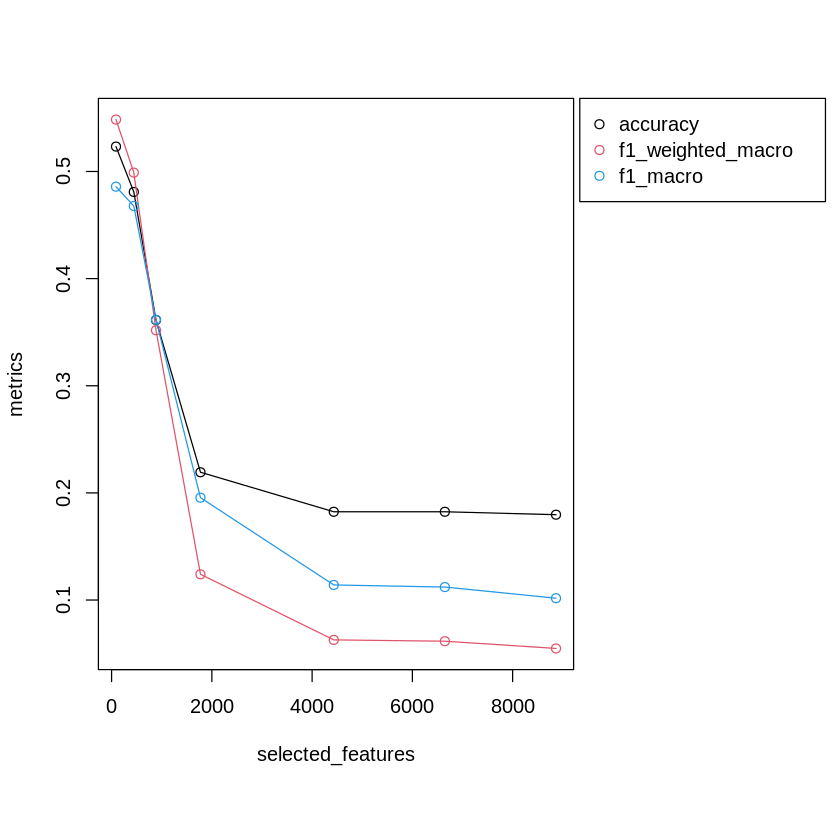

In [9]:
acc_list <- nb_metrics[[char(selected_features[1])]][["accuracy"]]
f1_w_list <- nb_metrics[[char(selected_features[1])]][["f1_weighted_macro"]]
f1_list <- nb_metrics[[char(selected_features[1])]][["f1_macro"]]
for(num_features in selected_features[2:length(selected_features)]) {
  acc_list <- c(acc_list, nb_metrics[[char(num_features)]][["accuracy"]])
  f1_w_list <- c(f1_w_list, nb_metrics[[char(num_features)]][["f1_weighted_macro"]])
  f1_list <- c(f1_list, nb_metrics[[char(num_features)]][["f1_macro"]])
}

metrics <- cbind(acc_list, f1_w_list, f1_list)
par(mar=c(7.1, 4.1, 4.1, 11.1), xpd=TRUE) # B, L, T, R
matplot(selected_features, metrics, type = c("o"), lty = 1, pch=1, col = c(1,2,4))
legend("topright", inset=c(-0.53,0), legend = c("accuracy", "f1_weighted_macro", "f1_macro"), col=c(1,2,4), pch=1)

#### Test

The Naive Bayes model which obtained the best performance on the validation set is now created and evaluated on the test set.

In [10]:
nb <- NBTrainer$new()
nb$fit(data.table(cbind(x_train[,1:max_accuracy_features], target_label = x_train$target_label)), "target_label")
predictions <- nb$predict(x_test[,1:max_accuracy_features])

In [11]:
models_names <- c("naive_bayes")
best_metrics[["naive_bayes"]] <- hash()
best_metrics[["naive_bayes"]][["n_samples"]] <- nrow(x_test)
best_metrics[["naive_bayes"]][["accuracy"]] <- Accuracy(predictions, x_test$target_label)
best_metrics[["naive_bayes"]][["f1_weighted_macro"]] <- F1_weighted_macro(x_test$target_label, predictions)
best_metrics[["naive_bayes"]][["f1_macro"]] <- F1_macro(x_test$target_label, predictions)

cat("Metrics computed on test set using", max_accuracy_features, "features\n")
cat("Accuracy:", best_metrics[["naive_bayes"]][["accuracy"]], "\n")
cat("F1 weighted macro:", best_metrics[["naive_bayes"]][["f1_weighted_macro"]], "\n")
cat("F1 macro:", best_metrics[["naive_bayes"]][["f1_macro"]], "\n")

Metrics computed on test set using 88 features
Accuracy: 0.5208476 
F1 weighted macro: 0.5531782 
F1 macro: 0.4785024 


### Gradient Boosting Decision Trees

#### Training

Many GBDT models are trained varying both the input features number and the depths of the decision trees. The 3 metrics (accuracy, weighted macro f1-score, macro f1-score) are assessed using the validation set for all the combinations of the hyper-parameters.

The training can require some hours, consider to reduce the hyperparameters' ranges to speed up the process.

In [ ]:
gbdt_metrics <- hash()
for(num_features in selected_features) {
  gbdt_metrics[[char(num_features)]] <- hash()
  gbdt_metrics[[char(num_features)]][["accuracy"]] <- numeric()
  gbdt_metrics[[char(num_features)]][["f1_weighted_macro"]] <- numeric()
  gbdt_metrics[[char(num_features)]][["f1_macro"]] <- numeric()
}

depths <- as.integer(seq(5, 60, by=5))

for(num_features in selected_features) {
  for(depth in depths) {
    cat("Features:", num_features, ", depth:", depth, "\n")
    xgb <- XGBTrainer$new(n_estimators = 10, objective = "multi:softmax", num_class = 3, max_depth = depth)
    xgb$fit(data.table(cbind(x_train[,1:num_features], target_label = x_train$target_label)), "target_label")
    predictions <- xgb$predict(x_val[,1:num_features])
    gbdt_metrics[[char(num_features)]][["accuracy"]] <- c(gbdt_metrics[[char(num_features)]][["accuracy"]], Accuracy(predictions, x_val$target_label))
    gbdt_metrics[[char(num_features)]][["f1_weighted_macro"]] <- c(gbdt_metrics[[char(num_features)]][["f1_weighted_macro"]], F1_weighted_macro(x_val$target_label, predictions))
    gbdt_metrics[[char(num_features)]][["f1_macro"]] <- c(gbdt_metrics[[char(num_features)]][["f1_macro"]], F1_macro(x_val$target_label, predictions))
  }
}

Best metrics obtained on validation set:

In [13]:
max_accuracy <- 0
max_f1_weighted_macro <- 0
max_f1_macro <- 0
for(num_features in selected_features) {
  if (max_accuracy < max(gbdt_metrics[[char(num_features)]][["accuracy"]])) {
    max_accuracy <- max(gbdt_metrics[[char(num_features)]][["accuracy"]])
    max_accuracy_features <- num_features
    max_accuracy_depth <- depths[which.max(gbdt_metrics[[char(num_features)]][["accuracy"]])]
  }
  if (max_f1_weighted_macro < max(gbdt_metrics[[char(num_features)]][["f1_weighted_macro"]])) {
    max_f1_weighted_macro <- max(gbdt_metrics[[char(num_features)]][["f1_weighted_macro"]])
    max_f1_weighted_macro_features <- num_features
    max_f1_weighted_macro_depth <- depths[which.max(gbdt_metrics[[char(num_features)]][["f1_weighted_macro"]])]
  }
  if (max_f1_macro < max(gbdt_metrics[[char(num_features)]][["f1_macro"]])) {
    max_f1_macro <- max(gbdt_metrics[[char(num_features)]][["f1_macro"]])
    max_f1_macro_features <- num_features
    max_f1_macro_depth <- depths[which.max(gbdt_metrics[[char(num_features)]][["f1_macro"]])]
  }
}

cat("Best metrics computed on validation set:\n")
cat("Max accuracy:", max_accuracy, "for depth", max_accuracy_depth, "using", max_accuracy_features, "features\n")
cat("Max f1 weighted macro:", max_f1_weighted_macro, "for depth", max_f1_weighted_macro_depth, "using", max_f1_weighted_macro_features, "features\n")
cat("Max f1 macro:", max_f1_macro, "for depth", max_f1_macro_depth, "using", max_f1_macro_features, "features\n")

Best metrics computed on validation set:
Max accuracy: 0.7472678 for depth 55 using 886 features
Max f1 weighted macro: 0.7386662 for depth 55 using 1773 features
Max f1 macro: 0.6760004 for depth 40 using 1773 features


Plots of the 3 metrics with respect to number of features choosen and decision trees' depths.

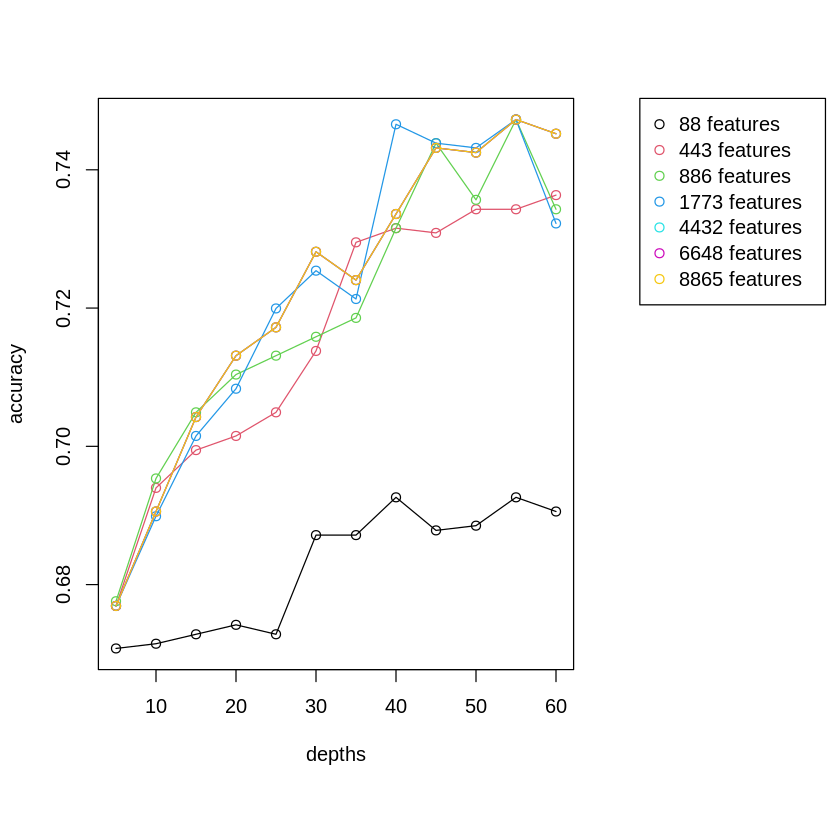

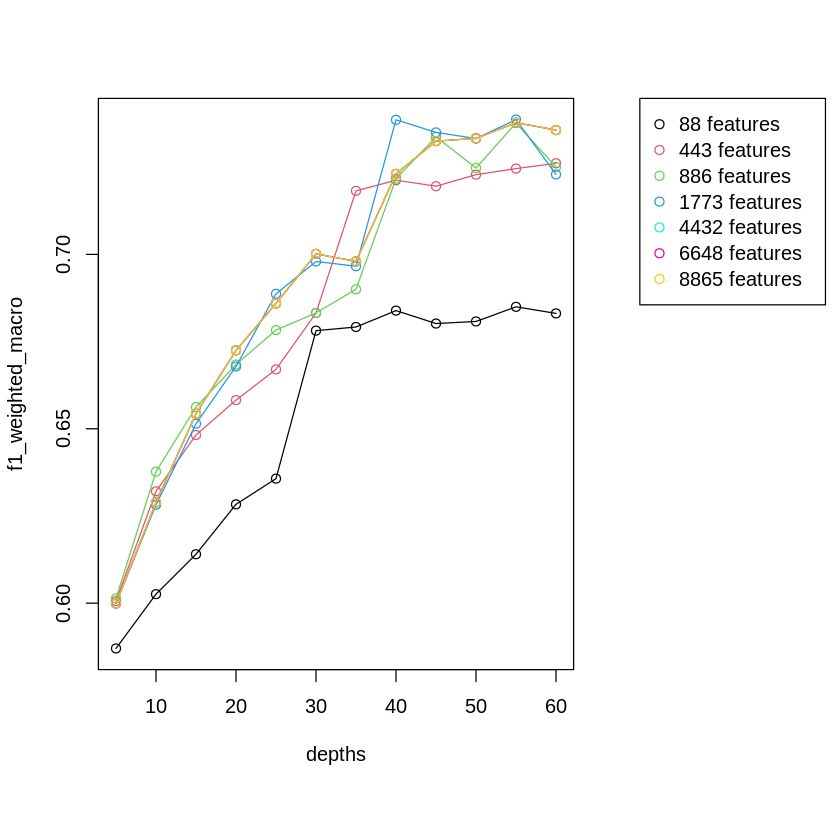

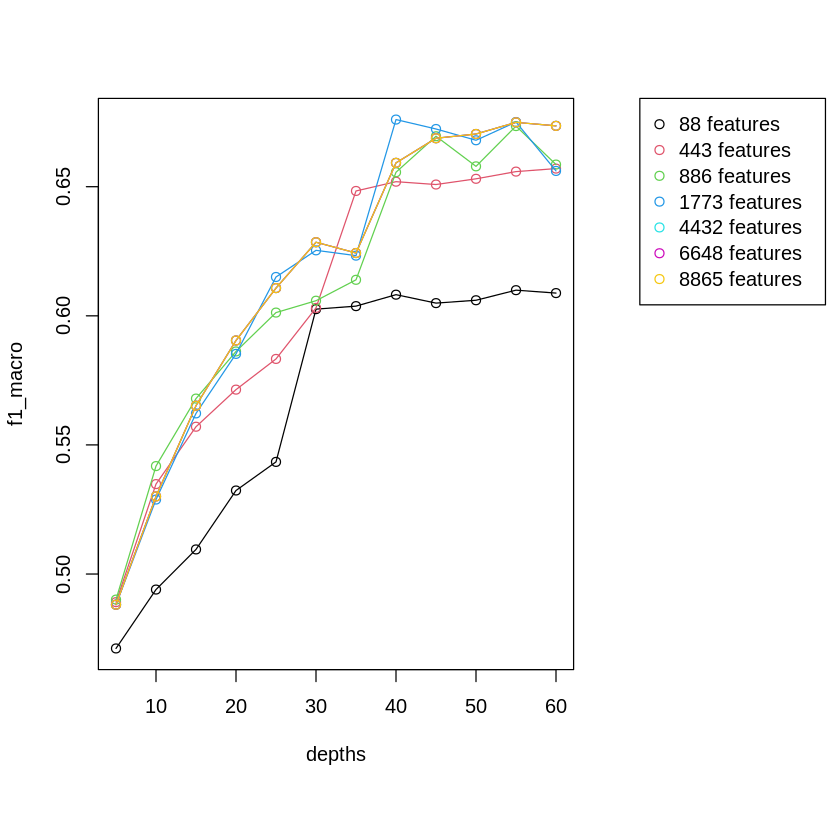

In [14]:
legend_vector <- c(paste(selected_features[1], "features"))
for(num_features in selected_features[2:length(selected_features)]) {
  legend_vector <- cbind(legend_vector, paste(num_features, "features"))
}

for(metric in c("accuracy", "f1_weighted_macro", "f1_macro")) {
  metrics <- gbdt_metrics[[char(selected_features[1])]][[metric]]
  for(num_features in selected_features[2:length(selected_features)]) {
    metrics <- cbind(metrics, gbdt_metrics[[char(num_features)]][[metric]])
  }
  par(mar=c(7.1, 4.1, 4.1, 11.1), xpd=TRUE) # B, L, T, R
  matplot(depths, metrics, type = c("o"), lty = 1, pch=1, col = c(1:7), ylab=metric)
  legend("topright", inset=c(-0.53,0), legend = legend_vector, col=c(1:7), pch=1)
}

#### Test

In this section the models are created using the best hyper-parameters found for the metrics and then their performances are evaluated using the test set.

Model with best accuracy:

In [ ]:
xgb <- XGBTrainer$new(n_estimators = 10, objective = "multi:softmax", num_class = 3, max_depth = max_accuracy_depth)
xgb$fit(data.table(cbind(x_train[,1:max_accuracy_features], target_label = x_train$target_label)), "target_label")
predictions <- xgb$predict(x_test[,1:max_accuracy_features])

In [16]:
models_names <- c(models_names, "gbdt_top_accuracy")
best_metrics[["gbdt_top_accuracy"]] <- hash()
best_metrics[["gbdt_top_accuracy"]][["n_samples"]] <- nrow(x_test)
best_metrics[["gbdt_top_accuracy"]][["accuracy"]] <- Accuracy(predictions, x_test$target_label)
best_metrics[["gbdt_top_accuracy"]][["f1_weighted_macro"]] <- F1_weighted_macro(x_test$target_label, predictions)
best_metrics[["gbdt_top_accuracy"]][["f1_macro"]] <- F1_macro(x_test$target_label, predictions)

cat("Metrics computed on test set using depth=", max_accuracy_depth, "and features=", max_accuracy_features, "(hyperparameters which led to best accuracy)\n")
cat("Accuracy:", best_metrics[["gbdt_top_accuracy"]][["accuracy"]], "\n")
cat("F1 weighted macro:", best_metrics[["gbdt_top_accuracy"]][["f1_weighted_macro"]], "\n")
cat("F1 macro:", best_metrics[["gbdt_top_accuracy"]][["f1_macro"]], "\n")

Metrics computed on test set using depth= 55 and features= 886 (hyperparameters which led to best accuracy)
Accuracy: 0.7771702 
F1 weighted macro: 0.7720271 
F1 macro: 0.704779 


Model with best weighted macro f1-score:

In [ ]:
xgb <- XGBTrainer$new(n_estimators = 10, objective = "multi:softmax", num_class = 3, max_depth = max_f1_weighted_macro_depth)
xgb$fit(data.table(cbind(x_train[,1:max_f1_weighted_macro_features], target_label = x_train$target_label)), "target_label")
predictions <- xgb$predict(x_test[,1:max_f1_weighted_macro_features])

In [18]:
models_names <- c(models_names, "gbdt_top_f1_weighted_macro")
best_metrics[["gbdt_top_f1_weighted_macro"]] <- hash()
best_metrics[["gbdt_top_f1_weighted_macro"]][["n_samples"]] <- nrow(x_test)
best_metrics[["gbdt_top_f1_weighted_macro"]][["accuracy"]] <- Accuracy(predictions, x_test$target_label)
best_metrics[["gbdt_top_f1_weighted_macro"]][["f1_weighted_macro"]] <- F1_weighted_macro(x_test$target_label, predictions)
best_metrics[["gbdt_top_f1_weighted_macro"]][["f1_macro"]] <- F1_macro(x_test$target_label, predictions)

cat("Metrics computed on test set using depth=", max_f1_weighted_macro_depth, "and features=", max_f1_weighted_macro_features, "(hyperparameters which led to best weighted macro f1-score)\n")
cat("Accuracy:", best_metrics[["gbdt_top_f1_weighted_macro"]][["accuracy"]], "\n")
cat("F1 weighted macro:", best_metrics[["gbdt_top_f1_weighted_macro"]][["f1_weighted_macro"]], "\n")
cat("F1 macro:", best_metrics[["gbdt_top_f1_weighted_macro"]][["f1_macro"]], "\n")

Metrics computed on test set using depth= 55 and features= 1773 (hyperparameters which led to best weighted macro f1-score)
Accuracy: 0.7785373 
F1 weighted macro: 0.7721792 
F1 macro: 0.7044151 


Model with best macro f1-score:

In [ ]:
xgb <- XGBTrainer$new(n_estimators = 10, objective = "multi:softmax", num_class = 3, max_depth = max_f1_macro_depth)
xgb$fit(data.table(cbind(x_train[,1:max_f1_macro_features], target_label = x_train$target_label)), "target_label")
predictions <- xgb$predict(x_test[,1:max_f1_macro_features])

In [20]:
models_names <- c(models_names, "gbdt_top_f1_macro")
best_metrics[["gbdt_top_f1_macro"]] <- hash()
best_metrics[["gbdt_top_f1_macro"]][["n_samples"]] <- nrow(x_test)
best_metrics[["gbdt_top_f1_macro"]][["accuracy"]] <- Accuracy(predictions, x_test$target_label)
best_metrics[["gbdt_top_f1_macro"]][["f1_weighted_macro"]] <- F1_weighted_macro(x_test$target_label, predictions)
best_metrics[["gbdt_top_f1_macro"]][["f1_macro"]] <- F1_macro(x_test$target_label, predictions)

cat("Metrics computed on test set using depth=", max_f1_macro_depth, "and features=", max_f1_macro_features, "(hyperparameters which led to best macro f1-score)\n")
cat("Accuracy:", best_metrics[["gbdt_top_f1_macro"]][["accuracy"]], "\n")
cat("F1 weighted macro:", best_metrics[["gbdt_top_f1_macro"]][["f1_weighted_macro"]], "\n")
cat("F1 macro:", best_metrics[["gbdt_top_f1_macro"]][["f1_macro"]], "\n")

Metrics computed on test set using depth= 40 and features= 1773 (hyperparameters which led to best macro f1-score)
Accuracy: 0.7751196 
F1 weighted macro: 0.7691607 
F1 macro: 0.6997911 


### Sentiment Scores

In this section the sentiments assigned to the tweets using the `syuzhet` package are compared to the labels in the dataset and the performance are evaluated according to the 3 metrics. The entire dataset is used as test set since no training is needed.

The vectors `syuzhet_vector`, `bing_vector`, `afinn_vector` and `nrc_vector` refer to the sentiments computed using the syuzhet, bing, afinn and nrc methods respectively. 

The function `get_positive_class` is defined such that the scores are mapped to positive classes (to comply with the `F1_Score` function).

In [75]:
get_positive_class <- function(x) {
  if (x == "positive" || x == 1) {
    return (2)
  } 
  else if (x == "negative" || x == -1) {
    return (0)
  }
  else {
    return (1)
  }
}

In [77]:
# Obtain the sentiment scores
syuzhet_vector_raw <- get_sentiment(text, method="syuzhet")
bing_vector_raw <- get_sentiment(text, method="bing")
afinn_vector_raw <- get_sentiment(text, method="afinn")
nrc_vector_raw <- get_sentiment(text, method="nrc")

# Map the scores and the true labels into {0, 1, 2} classes
syuzhet_vector_list <- map(sign(syuzhet_vector_raw), get_positive_class)
syuzhet_vector <- as.numeric(unlist(syuzhet_vector_list))

bing_vector_list <- map(sign(bing_vector_raw), get_positive_class)
bing_vector <- as.numeric(unlist(bing_vector_list))

afinn_vector_list <- map(sign(afinn_vector_raw), get_positive_class)
afinn_vector <- as.numeric(unlist(afinn_vector_list))

nrc_vector_list <- map(sign(nrc_vector_raw), get_positive_class)
nrc_vector <- as.numeric(unlist(nrc_vector_list))

airline_sentiment_list <- map(df[["airline_sentiment"]], get_positive_class)
airline_sentiment <- as.numeric(unlist(airline_sentiment_list))

#### Syuzhet

In [83]:
models_names <- c(models_names, "syuzhet")
best_metrics[["syuzhet"]] <- hash()
best_metrics[["syuzhet"]][["n_samples"]] <- length(airline_sentiment)
best_metrics[["syuzhet"]][["accuracy"]] <- Accuracy(syuzhet_vector, airline_sentiment)
best_metrics[["syuzhet"]][["f1_weighted_macro"]] <- F1_weighted_macro(airline_sentiment, syuzhet_vector)
best_metrics[["syuzhet"]][["f1_macro"]] <- F1_macro(airline_sentiment, syuzhet_vector)

cat("Metrics computed on entire dataset\n")
cat("Accuracy:", best_metrics[["syuzhet"]][["accuracy"]], "\n")
cat("F1 weighted macro:", best_metrics[["syuzhet"]][["f1_weighted_macro"]], "\n")
cat("F1 macro:", best_metrics[["syuzhet"]][["f1_macro"]], "\n")

Metrics computed on entire dataset
Accuracy: 0.4808743 
F1 weighted macro: 0.5055607 
F1 macro: 0.4465174 


#### Bing

In [84]:
models_names <- c(models_names, "bing")
best_metrics[["bing"]] <- hash()
best_metrics[["bing"]][["n_samples"]] <- length(airline_sentiment)
best_metrics[["bing"]][["accuracy"]] <- Accuracy(bing_vector, airline_sentiment)
best_metrics[["bing"]][["f1_weighted_macro"]] <- F1_weighted_macro(airline_sentiment, bing_vector)
best_metrics[["bing"]][["f1_macro"]] <- F1_macro(airline_sentiment, bing_vector)

cat("Metrics computed on entire dataset\n")
cat("Accuracy:", best_metrics[["bing"]][["accuracy"]], "\n")
cat("F1 weighted macro:", best_metrics[["bing"]][["f1_weighted_macro"]], "\n")
cat("F1 macro:", best_metrics[["bing"]][["f1_macro"]], "\n")

Metrics computed on entire dataset
Accuracy: 0.5124317 
F1 weighted macro: 0.5336915 
F1 macro: 0.5027732 


#### Afinn

In [85]:
models_names <- c(models_names, "afinn")
best_metrics[["afinn"]] <- hash()
best_metrics[["afinn"]][["n_samples"]] <- length(airline_sentiment)
best_metrics[["afinn"]][["accuracy"]] <- Accuracy(afinn_vector, airline_sentiment)
best_metrics[["afinn"]][["f1_weighted_macro"]] <- F1_weighted_macro(airline_sentiment, afinn_vector)
best_metrics[["afinn"]][["f1_macro"]] <- F1_macro(airline_sentiment, afinn_vector)

cat("Metrics computed on entire dataset\n")
cat("Accuracy:", best_metrics[["afinn"]][["accuracy"]], "\n")
cat("F1 weighted macro:", best_metrics[["afinn"]][["f1_weighted_macro"]], "\n")
cat("F1 macro:", best_metrics[["afinn"]][["f1_macro"]], "\n")

Metrics computed on entire dataset
Accuracy: 0.5003415 
F1 weighted macro: 0.5236003 
F1 macro: 0.4726793 


#### Nrc

In [86]:
models_names <- c(models_names, "nrc")
best_metrics[["nrc"]] <- hash()
best_metrics[["nrc"]][["n_samples"]] <- length(airline_sentiment)
best_metrics[["nrc"]][["accuracy"]] <- Accuracy(nrc_vector, airline_sentiment)
best_metrics[["nrc"]][["f1_weighted_macro"]] <- F1_weighted_macro(airline_sentiment, nrc_vector)
best_metrics[["nrc"]][["f1_macro"]] <- F1_macro(airline_sentiment, nrc_vector)

cat("Metrics computed on entire dataset\n")
cat("Accuracy:", best_metrics[["nrc"]][["accuracy"]], "\n")
cat("F1 weighted macro:", best_metrics[["nrc"]][["f1_weighted_macro"]], "\n")
cat("F1 macro:", best_metrics[["nrc"]][["f1_macro"]], "\n")

Metrics computed on entire dataset
Accuracy: 0.3486339 
F1 weighted macro: 0.3646083 
F1 macro: 0.3433422 


### Models comparison

It is evaluated wheter it exists or not a statistically significant difference between the models based on their performances on the test set (for ML models) and on the entire dataset (for methods from the `syuzhet` package).

The statistical reasoning to compare the models is based on the following concept: we can assert with a given confidence that each metric is inside a given interval, which depends both on the confidence (the higher the confidence, the larger the interval) and on the number of test samples (the more the samples, the narrower the interval).

In particular, we compute the difference of a given metric of 2 models: if the related confidence interval does not contain the zero, then the 2 metrics are statistically different, otherwise no. 

In [95]:
# Determines whether the difference for a given metric of models A and B is statistically significant
model_comparison <- function(metric_A, metric_B, N_A, N_B, confidence) {
  # Compute Z value for given alpha
  alpha = 1 - confidence
  z = abs(qnorm(alpha/2))
  # Models error
  error_A = 1 - metric_A
  error_B = 1 - metric_B
  # Error difference estimation
  d = abs(error_A - error_B)
  # Difference interval
  sigma_d = sqrt((error_A * metric_A) / N_A + (error_B * metric_B) / N_B)
  d_min = d - z * sigma_d
  d_max = d + z * sigma_d
  if (d_min <= 0 && d_max >= 0) {
    return (0) # Difference is not significant
  } else {
    return (1) # Difference is significant
  }
}

The models are compared pairwise for each of the 3 metrics available.

In [99]:
confidence = 0.99
cat("The following statements are done with a confidence of ", confidence*100, "%\n", sep = "")
for (metric in c("accuracy", "f1_weighted_macro", "f1_macro")) {
  cat("\n-------------- ", metric, " --------------\n", sep = "")
  for (model_A in models_names[1:length(models_names)-1]) {
    offset = match(model_A, models_names) + 1
    for (model_B in models_names[offset:length(models_names)]) {
      d <- model_comparison(best_metrics[[model_A]][[metric]], best_metrics[[model_B]][[metric]], best_metrics[[model_A]][["n_samples"]], best_metrics[[model_B]][["n_samples"]], confidence)
      if (d == 0) {
        cat("No statistical difference between models \"", model_A, "\" and \"", model_B, "\"\n", sep = "")
      } else {
        if (best_metrics[[model_A]][[metric]] > best_metrics[[model_B]][[metric]]) {
          cat("\"", model_A, "\" is statistically BETTER than \"", model_B, "\"\n", sep = "")
        } else {
          cat("\"", model_A, "\" is statistically WORSE than \"", model_B, "\"\n", sep = "")
        }
      }
    }
    cat("\n")
  }
}

The following statements are done with a confidence of 99%

-------------- accuracy --------------
"naive_bayes" is statistically WORSE than "gbdt_top_accuracy"
"naive_bayes" is statistically WORSE than "gbdt_top_f1_weighted_macro"
"naive_bayes" is statistically WORSE than "gbdt_top_f1_macro"
"naive_bayes" is statistically BETTER than "syuzhet"
No statistical difference between models "naive_bayes" and "bing"
No statistical difference between models "naive_bayes" and "afinn"
"naive_bayes" is statistically BETTER than "nrc"

No statistical difference between models "gbdt_top_accuracy" and "gbdt_top_f1_weighted_macro"
No statistical difference between models "gbdt_top_accuracy" and "gbdt_top_f1_macro"
"gbdt_top_accuracy" is statistically BETTER than "syuzhet"
"gbdt_top_accuracy" is statistically BETTER than "bing"
"gbdt_top_accuracy" is statistically BETTER than "afinn"
"gbdt_top_accuracy" is statistically BETTER than "nrc"

No statistical difference between models "gbdt_top_f1_weighted_